<a id="top"></a>
<h1 align="center">MCMC Tutorial Part 4</h1>

<br>

**Authors:** John Letey, Mingxuan Zhang, H. Nihar Nandan, and Tony E. Wong

In the last part of the tutorial, we will look at something called the AR1 process. It stands for Auto-regressive 1 process.  This is a specific type of the auto-regressive formula which we will use to calculate the likelihood with better accuracy.

In the first chapter when we calculate the residuals, i.e., these are completely independent values, but in the AR1 process, we add white noise to these residuals since each state is dependent on the previous state. This white noise is a parameter that is part of our estimation and is not a constant. For each state in our Markov Chain, we will have a different white noise value.
### Table of Contents

- [Packages](#packages)
- [Data](#data)
- [Interpretations](#interpretations)
- [Math](#math)
- [Functions](#functions)
- [Plots](#plots)
- [Conclusions](#conclusions)

<a id="packages"></a>
***
<h2 align="center">Packages</h2>
[Back to top](#top)

For this part of the tutorial, we will be using the following packages -

In [7]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%config InlineBackend.figure_format='retina'
from pprint import pprint
COLORS = ["skyblue", "steelblue", "gray"]
ALPHAS = [1.0, 1.0, 0.45]

<a id="data"></a>
***
<h2 align="center">Data</h2>
[Back to top](#top)

For this part of the tutorial, we will be using the following packages -

In [9]:
year = []
sealevel = []
sealevel_sigma = []
temperature = []

#dfSealevel = pd.read_csv("data_sealevel.csv")
#dfTemperature = pd.read_csv("data_temperature.csv")
dfSealevel = pd.read_csv('GMSL_ChurchWhite2011_yr_2015.csv')
dfTemperature = pd.read_csv('NOAA_IPCC_RCPtempsscenarios.csv')
year = dfSealevel["year"].tolist()
sealevel = dfSealevel["sealevel"].tolist()

In [10]:
dfSealevel.head()

,year,sealevel,uncertainty
0,1880.5,-158.7,24.2
1,1881.5,-153.1,24.2
2,1882.5,-169.9,23.0
3,1883.5,-164.6,22.8
4,1884.5,-143.7,22.2


In [11]:
dfTemperature.head()

,Time,Historical NOAA temp. respect to 20th century,CNRM annual RCP8.5 temp. with respect to 20th century,Historical NOAA temp & CNRM RCP 8.5 with respect to 20th century,IPCC Year,max#5.795,min#1.373,a1fi#4.492,alb#2.947,alt#2.538,a2#3.794,b1#1.982,b2#2.687
0,1880,-0.16,-0.125997,-0.16,1880.0,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16
1,1881,-0.10,-0.185231,-0.10,1885.0,-0.20,-0.20,-0.20,-0.20,-0.20,-0.20,-0.20,-0.20
2,1882,-0.12,0.016642,-0.12,1890.0,-0.30,-0.30,-0.30,-0.30,-0.30,-0.30,-0.30,-0.30
3,1883,-0.17,-0.340016,-0.17,1895.0,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25
4,1884,-0.23,-0.856588,-0.23,1900.0,-0.11,-0.11,-0.11,-0.11,-0.11,-0.11,-0.11,-0.11


The column that we are going to be using from the `dfTemperature` dataset is - Historical NOAA temp & CNRM RCP 8.5 with respect to 20th century. These are normalized global temperatures w.r.t to the average value of the 20th century. These also contain estimate values that go up to 2100.

In [12]:
sealevel_sigma = dfSealevel["uncertainty"].tolist()

In [13]:
temperatures = dfTemperature.loc[dfTemperature["Time"] <= 2013, "Historical NOAA temp & CNRM RCP 8.5 with respect to 20th century"]

This slices the list and stores values only till 2013.

<a id="interpretations"></a>
***
<h2 align="center">Interpretations</h2>
[Back to top](#top)

We can draw some conclusion by analyzing the dataset. This will help us understand the limitations to our final estimate of the parameters and will also help us in realizing the true potential of such a technique.

The first graph which is the sea level graph, should look familiar. As evidenced by everyday reports, the sea levels are constantly rising over the years. 

The second graph is the uncertainty in the methods we have used/use in measuring sea levels. Obviously, technology has improved immensely through the 20th century, so the error in measurements have decreased substantially as compared to the 1900's. There is a small spike in uncertainty as we move towards 2020 because these sea levels are predictions of the future, and estimates usually have higher uncertainties than real values.

The final graph is the global temperature of the world. This is not the  temperature of the water, but of the air just above the water. Again, this is goes up as proved by global warming. 

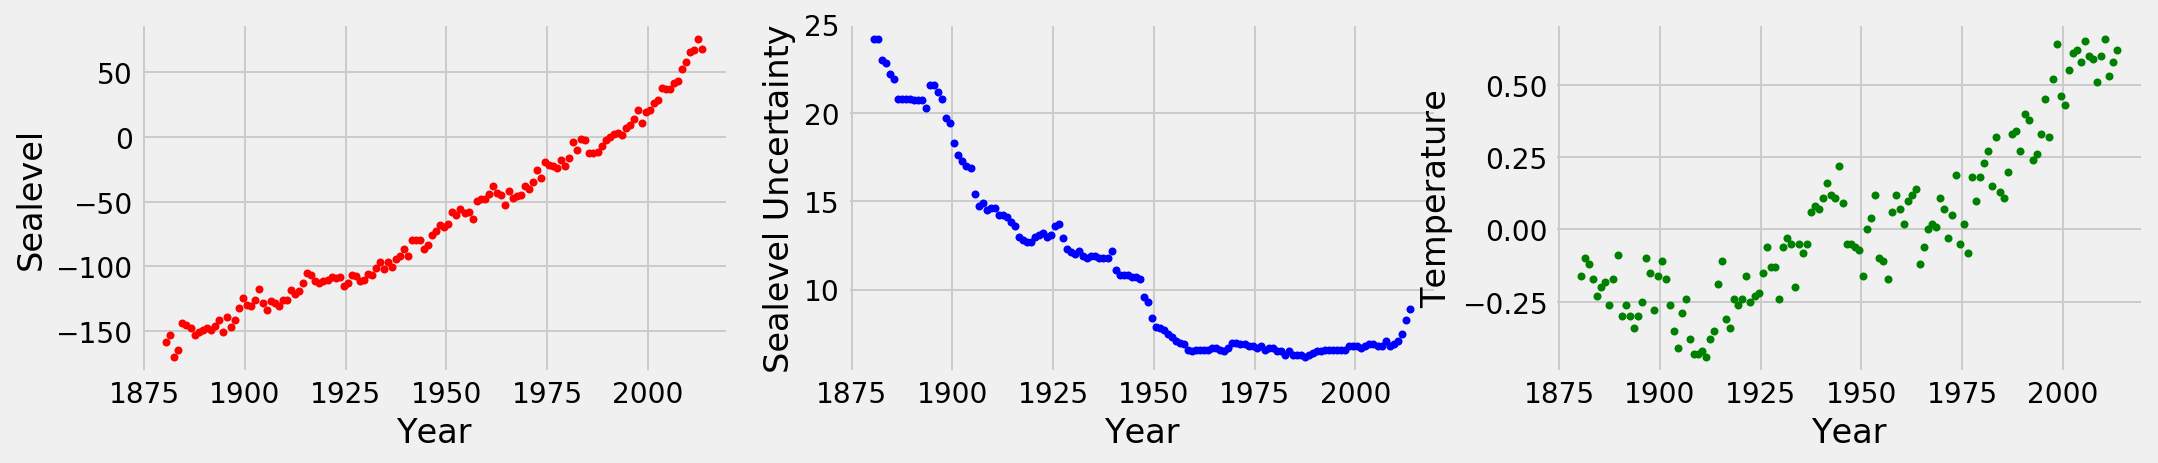

In [14]:
fig,ax = plt.subplots(nrows = 1, ncols = 3,figsize=(16,3))
ax[0].plot(year,sealevel,'r.')
ax[1].plot(year,sealevel_sigma,'b.')
ax[2].plot(year,temperatures,'g.')
ax[0].set_ylabel('Sealevel')
ax[1].set_ylabel('Sealevel Uncertainty')
ax[2].set_ylabel('Temperature')
for i in range(3): ax[i].set_xlabel('Year')
plt.show()

<a id="math"></a>
***
<h2 align="center">Math</h2>
[Back to top](#top)

The math for calculating the log-posterior score -

Suppose each of our residuals is represented by $\phi$, so our $n^{th}$ residual will be represented as $\phi_n$. In a sea level model, generally the current year's sea level is dependent on the previous year. So if temperatures were very hot last year, the sea level can be expected to be high in the current year. And the previous year's sea level will be dependent on the year before that and so forth. Including this dependency in our Markov Model is helpful, but it is even more helpful if we include this dependency when calculating the residuals in our likelihood estimation. We can achieve this by adding a variable which is some white noise dependent on the previous residual. This white-noise $\epsilon_n$ is sampled from a Multivariate Normal Distribution $~N(0, \sigma^2_{AR1})$.

The general equation for calculating our residuals this way will look like -

$$
\phi_n = \rho\phi_{n-1} + \epsilon_n
$$

To calculate the uncertainty of this residual value -

$$
Var(\phi_n) = Var(\rho\phi_{n-1} + \epsilon_n)
$$

$$
\sigma^2 = \rho^2 \times \sigma^2 + Var(\epsilon_n)
$$

$$
\sigma^2 = \rho^2 \times \sigma^2 + Var(\epsilon_n)
$$

$$
\sigma^2 = \frac{\sigma_{AR1}^2}{1-\rho^2}
$$

So for each observation, the variance can be calculated using the above equation. But it would be complex to do it for each residual for different lag values, so we can use a matrix which contains all these values and then we can use the multivariate normal function to calculate the log-likelihood value.
The AR1 matrix is -

$$
\begin{bmatrix}
1 & \rho & \rho^2 & \rho^3 & \rho^4 & ...... \\
\rho & 1 & \rho & \rho^2 & \rho^3 & ...... \\
\rho^2 & \rho & 1 & \rho & \rho^2 & ...... \\
\rho^3 & \rho^2 & \rho & 1 & \rho & ...... \\
.\\.\\.\\.
\end{bmatrix} \times \frac{\sigma^2}{1-\rho^2}
$$

The observation uncertainty matrix is -

$$
\begin{bmatrix}
\sigma_1 & 0 & 0 & 0 & 0 & ... \\
0 & \sigma_2 & 0 & 0 & 0 & ...\\
0 & 0 & \sigma_3 & 0 & 0 & ...\\
. \\ . \\ .
\end{bmatrix}
$$

We are going to calculate the log_likelihood using a sample from the multivariate normal distribution. The covariance parameter for the multivariate function will be the sum of the AR1 and the sigma_observation matrices.

We add the observation matrix to the AR1 matrix because this accounts for the uncertainty in the data.
<a id="functions"></a>
***
<h2 align="center">Functions</h2>
[Back to top](#top)

Below are the functions we are going to be using for the AR1 process.

1. `generate_level` - This will be used in calculating the log-posterior score for our likelihood function.
2. `build_ar1` - This is for building the AR1 matrix.
3. `update_cov` - This is the update_covariance from the first chapter. We are not using the online, but just calculating the covariance. (Will implement the online covariance update)
4. `prior` - For each of the 5 variables, we will calculate the log-posterior score independently and then sum them all together. 
5. `logp` - This is our log-posterior function. The final value calculated using this function will help us determine which value to accept/reject. 



In [15]:
def generate_level(paramaters, temperatures, deltat):
    alpha, Teq, S0 = parameters[0], parameters[1], parameters[2]
    S = [0]*(len(temperatures)+1)
    S[0] = S0
    for i in range(1,len(temperatures)+1):
        S[i] = S[i-1] + deltat * alpha * (temperatures[i-1] - Teq)
    return S[1:]

def build_ar1(rho, sigma_ar, length):
    ar1 = []
    for i in range(length):
        temp1 = [rho**j for j in range(i,0,-1)]
        temp2 = [rho**j for j in range(length-i)]
        ar1.append(np.array(temp1+temp2))
    ar1 = np.multiply(np.array(ar1), (sigma_ar**2)/(1-rho**2))
    return ar1

def update_cov(X, s_d):
    cov = np.cov([X[:,0],X[:,1],X[:,2],X[:,3],X[:,4]])
    eps = 0.0001
    I_d = np.identity(5)
    return s_d*cov + I_d*eps*s_d

def prior(theta, sealevel_0, unc_0):
    log_prior = 0
    #unpacking the variables individually for clarity
    alpha, Teq, S0, rho, sigma_ar = (
        theta[0], theta[1], theta[2], theta[3], theta[4])
    log_prior += stats.uniform.logpdf(alpha, loc = 0, scale = 5) #lb and ub?
    log_prior += stats.uniform.logpdf(Teq, loc=-1, scale = 2)
    log_prior += stats.norm.logpdf(S0, loc = sealevel_0, scale = unc_0)
    log_prior += stats.uniform.logpdf(rho, loc = 0, scale = 1)
    log_prior += stats.uniform.logpdf(sigma_ar, loc = 0, scale = 5)
    return log_prior

def logp(theta, sealevel, deltat, temperatures, sigma=sealevel_sigma):
    N = len(sealevel)
    alpha, Teq, S0, rho, sigma_ar = (
        theta[0], theta[1], theta[2], theta[3], theta[4])
    model = generate_level(theta, temperatures, deltat)
    resid = np.array([sealevel[i] - model[i] for i in range(len(model))])
    sigma_obs = np.diag([i**2 for i in sigma])
    sigma_ar1 = build_ar1(rho, sigma_ar, N)
    log_prior = prior(theta, sealevel[0], sealevel_sigma[0])
    if np.isinf(log_prior): return -np.inf
    cov = np.add(sigma_obs,sigma_ar1)
    cov = np.multiply((np.transpose(cov) + cov), 1/2)
    log_likelihood = stats.multivariate_normal.logpdf(resid, cov=cov)
    log_posterior = log_likelihood + log_prior
    return log_posterior

This `chain` function will be our function which implements the Markov Chain. It is very similar to our function from the first chapter. 

In [16]:
def chain(parameters, temperatures, deltat, sealevel, sealevel_sigma, N=10000):
    alpha, Teq, S0 = parameters[0], parameters[1], parameters[2]
    theta = parameters
    print('Initial estimate for parameters -', theta)

    lp = logp(theta, sealevel, deltat, temperatures, sigma=sealevel_sigma)
    theta_best = theta
    lp_max = lp
    theta_new = [0] * 5
    accepts = 0
    mcmc_chains = np.array([[0., 0., 0., 0., 0.]] * N)    
    step = np.array([[.1,0,0,0,0], [0,.05,0,0,0], [0,0,5,0,0],
                    [0,0,0,0.001,0],[0,0,0,0,0.1]])
    sd = 2.38**2 / len(theta)

    for i in range(N):
        if i > 500: step = update_cov(mcmc_chains[:i], sd)
        theta_new = list(np.random.multivariate_normal(theta, step))
        lp_new = logp(theta_new, sealevel, deltat, temperatures, sigma=sealevel_sigma)
        lq = lp_new - lp
        lr = np.math.log(np.random.uniform(0, 1))
        if (lr < lq):
            theta = theta_new
            lp = lp_new
            accepts += 1
            if lp > lp_max:
                theta_best = theta
                lp_max = lp
        mcmc_chains[i] = theta
    return mcmc_chains,accepts/N*100

## Calling our function with the right parameters -

The 5 parameters for our function are -

1. Parameters for the Markov Chain
    1. Alpha -
    2. Temperature Equilibrium -
    3. Initial sea level value of model -
    4. Rho -
    5. Uncertainty in AR1 matrix -
2. List of temperatures
3. The difference in Time - in our case it will be 1 year
4. List of sea levels
5. The uncertainties in sea level values from our dataset. 

In [17]:
parameters = [3.4, -0.5, sealevel[0], 0.5, 3]
deltat = 1
mcmc_chains,accept_rate = chain(parameters, temperatures, deltat, sealevel, sealevel_sigma)

Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]


<a id="plots"></a>
***
<h2 align="center">Plots</h2>
[Back to top](#top)

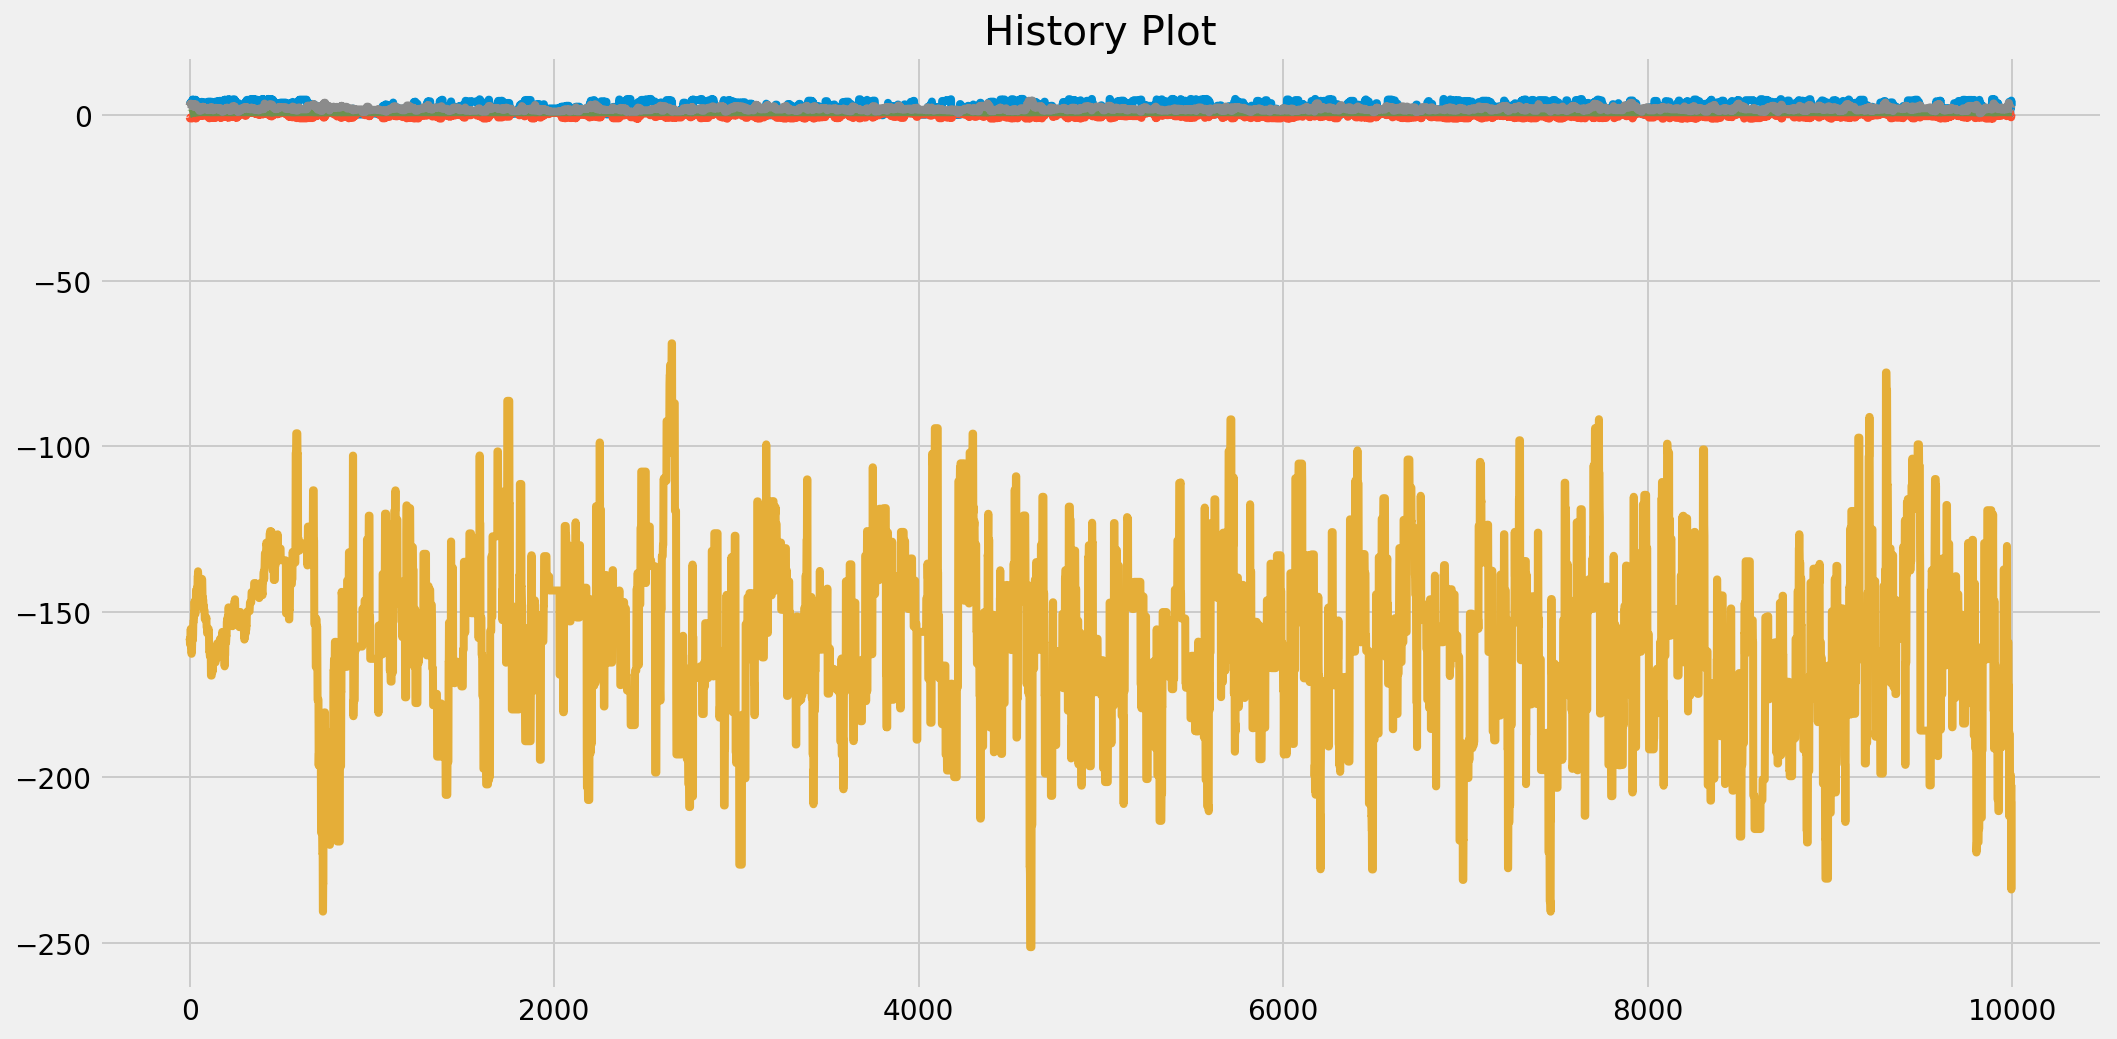

In [18]:
plt.figure(figsize = (16,8))
plt.plot(mcmc_chains)
plt.title('History Plot')
plt.show()

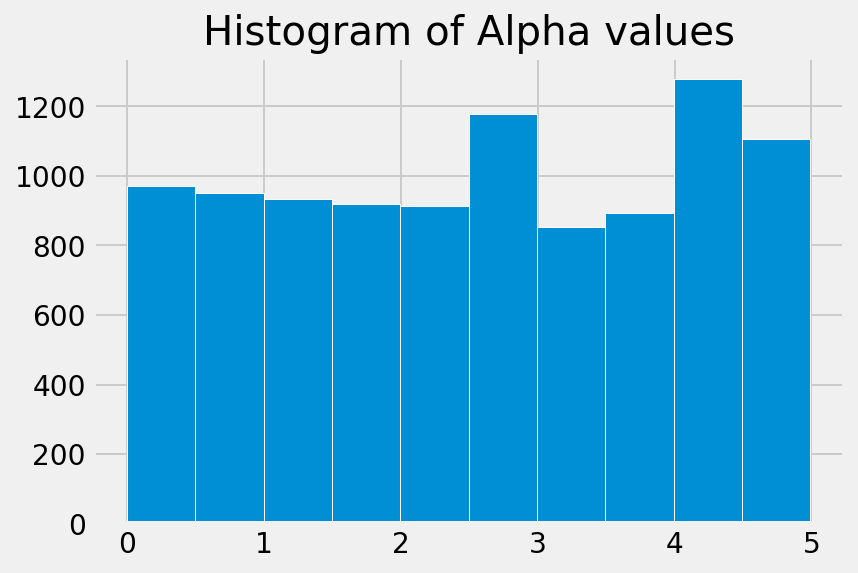

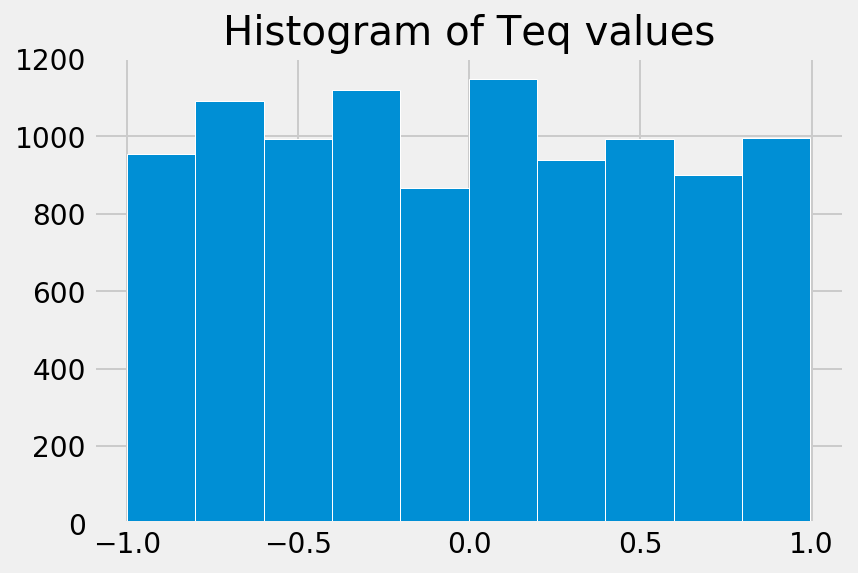

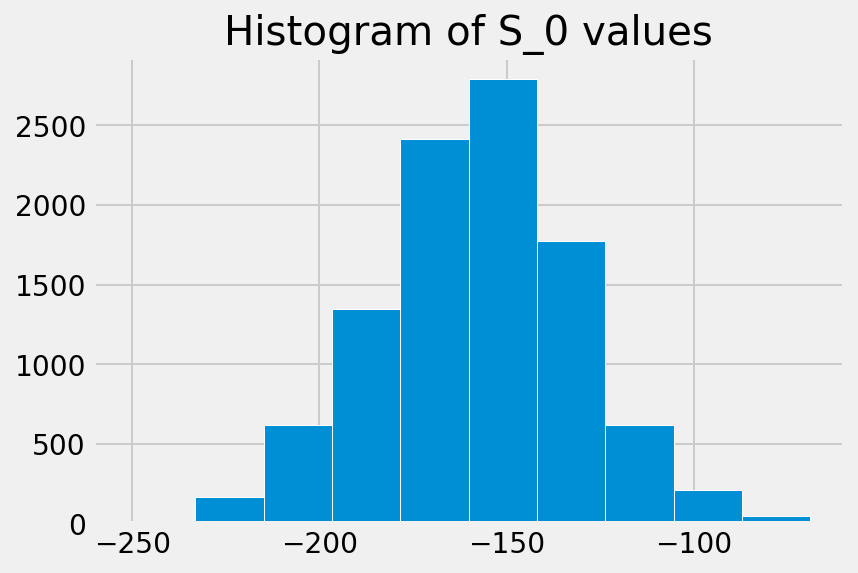

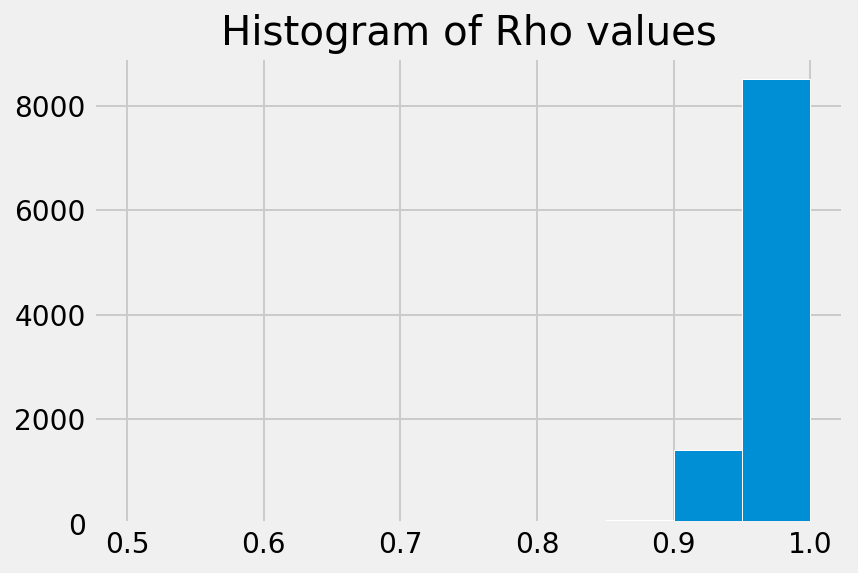

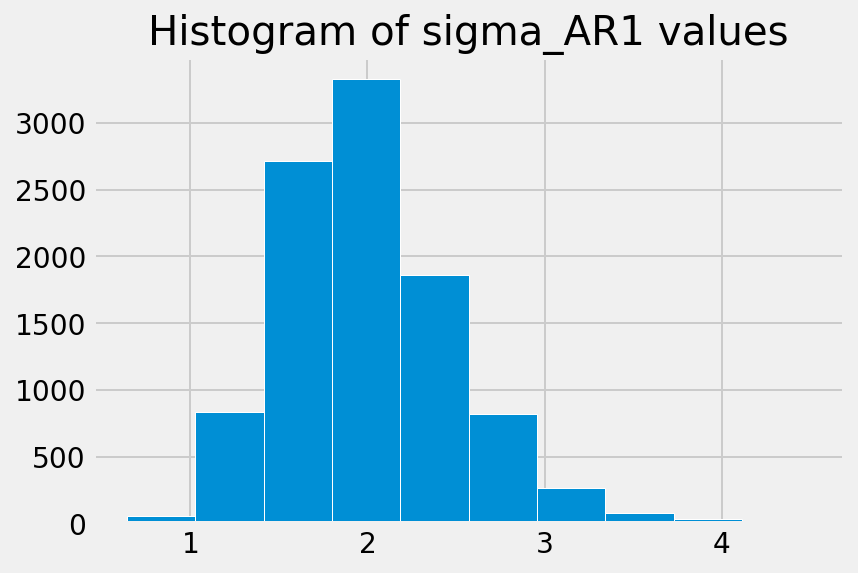

In [19]:
plt.hist(mcmc_chains[:,0], edgecolor = 'white')
plt.title('Histogram of Alpha values')
plt.show()

plt.hist(mcmc_chains[:,1], edgecolor = 'white')
plt.title('Histogram of Teq values')
plt.show()

plt.hist(mcmc_chains[:,2], edgecolor = 'white')
plt.title('Histogram of S_0 values')
plt.show()

plt.hist(mcmc_chains[:,3], edgecolor = 'white')
plt.title('Histogram of Rho values')
plt.show()

plt.hist(mcmc_chains[:,4], edgecolor = 'white')
plt.title('Histogram of sigma_AR1 values')
plt.show()

Acceptance Rate -

In [20]:
print(accept_rate)

18.14


Now that we have a single chain, let's calculate the Gelman-Rubin diagnostic to find out when our chains have burnt in. After that we will calculate the lag and thin our values.

In [22]:
mcmc_chains = []
N = 30000
m = 10

for i in range(m):
    mcmc_chain, accept_rate = chain(parameters, temperatures, deltat, sealevel, sealevel_sigma)
    mcmc_chains.append(mcmc_chain)
mcmc_chains = np.array(mcmc_chains)

Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]
Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]
Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]
Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]
Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]
Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]
Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]
Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]
Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]
Initial estimate for parameters - [3.4, -0.5, -158.7, 0.5, 3]


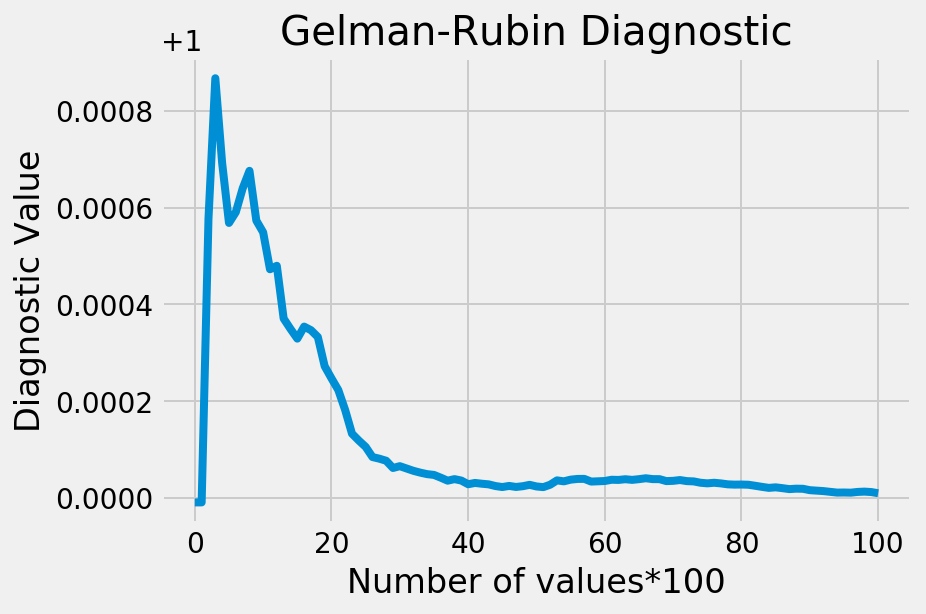

In [36]:
def diagnsotic(mcmc_chains):
    m = len(mcmc_chains)
    s_j = [np.var(mcmc_chains[i]) for i in range(m)]
    W = 1 / m * np.sum(s_j)
    global_mean = np.mean([np.mean(mcmc_chains[i]) for i in range(m)])
    B = N / (m - 1) * np.sum([(np.mean(mcmc_chains[i]) - global_mean)**2
                              for i in range(m)])
    Var = (1 - 1/N)*W + 1/N*B
    return np.sqrt(Var/W)

R = [(diagnsotic(mcmc_chains[:,0,:]))]
burn_in = 1

while burn_in < 10000:
    R.append(diagnsotic(mcmc_chains[:,:burn_in,:]))
    burn_in += 100

plt.plot(R)
plt.title('Gelman-Rubin Diagnostic')
plt.xlabel('Number of values*100')
plt.ylabel('Diagnostic Value')
plt.show()

<a id="conclusions"></a>
***
<h2 align="Center">Conclusions</h2>
[Back to top](#top)